<a href="https://colab.research.google.com/github/rfarwell/MPhys/blob/main/FinalFullDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch import reshape
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable

     |████████████████████████████████| 48.4 MB 19 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# /content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv
# Specify project folder location
project_folder = "/content/gdrive/MyDrive/Data"
clinical_data_filename = "NSCLC-Radiomics-Clinical-Data.csv"
print(os.path.join(project_folder, clinical_data_filename))

In [ ]:
#======================= DEFINE FUNCTIONS ======================================

def equalise_array_lengths(array_1, array_2) :
  """
  This functions takes in the arguments of two lists and makes sure they are returned as the same length.

  Rory Farwell 02/12/2021
  """
  # output_array = []
  if len(array_1) > len(array_2) :
    array_1 = array_1[:len(array_2)]
  elif len(array_1) < len(array_2) :
    array_2 = array_2[:len(array_1)]
  return (array_1, array_2)

def remove_same_elements(small_array, long_array) :
  """
  For use in the context, all the elements in small_array come from long_array.
  This function will remove all of the elements used in small_array from_long_array.  
  """
  for element in small_array :
    long_array.remove(element)
  return long_array

def create_subgroup(input_array, original_array_length, desired_percentage) :
  """
  This function outputs a subgroup array (e.g. training array) using a specified output array name,
  input array and percentage length
  """
  desired_length = int(original_array_length * desired_percentage)
  output_array = random.sample(input_array, desired_length)
  return output_array
  
#============================ OPEN METADATA FILE================================
# Open the metadata.csv file, convert to an array, and remove column headers
metadata_file = os.path.join(project_folder, clinical_data_filename)
print(f'metadata_file path: {metadata_file}')
metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
print(f"Length of metadata array is {len(metadata)}")

#============================ RETRIEVE INFO FROM METADATA FILE =================
patient_IDs = metadata[:,0] # selecting patient IDs from the csv file
time_markers = metadata[:,8] # selecting the day of the last patient review from the csv file
dead_statuses = metadata[:,9] # selecting the dead status on the last review day

time_markers = time_markers.astype(np.float32) # converting to float
dead_statuses = dead_statuses.astype(np.float32) # converting to float

#============================ DEFINING VARIABLES AND CREATING EMPTY ARRAYS =====
check_day = 365 * 1.5 # This is defining the timeframe for which our CNN will consider the binary output (in days) 

# sanity check to check progress
counter = 0 

# A counter of howe many patients are dead, alive or censored at the check day
dead_counter = 0
alive_counter = 0
no_info_counter = 0

# Empty arrays that will be appended to.
# They will be appended with the patient IDs and dead statuses on the check day
dead_patient_array = [] 
alive_patient_array = []

# Creating empty arrays that will be appended to later
# These will contain the patient ID and dead status (on the check day).
training_array = []
testing_array = []
validation_array = []

#=========================== CHECKING PATIENT DEAD STATUS ON CHECK DAY =========

# The below 'for' loop will check patient status on the check day and convert if necessary.
# Possibilites are:
# 1) If the patient is dead and the last review point is after than the check day then
# the patient is alive in the check day and so the dead status is changed in the new array
# 2) If the patient is dead and the last review point is before the check day then the patient
# is dead on the check day and their dead status is unchanged
# 3) If the patient is alive and their last review point is after the check day then they
# are alive at the check day and so their dead status remains unchanged
# 4) If the patient has status alive and their last review point is before the 
# check day then we don't know if they are alive at the check day so they are ignored from the list.
for i in range(len(dead_statuses)) :
  temp_patient_ID = patient_IDs[i]
  temp_dead_status = dead_statuses[i]
  temp_time_marker = time_markers[i]
  if temp_dead_status == 1 : #if the patient is dead
    if temp_time_marker < check_day :#confirms that the patient was dead after time 'check_day'
      dead_patient_array.append([temp_patient_ID, 1])
      dead_counter += 1
      continue
    elif temp_time_marker > check_day :
      alive_patient_array.append([temp_patient_ID, 0])
      alive_counter += 1
      continue
  elif temp_dead_status == 0 : #if the patient is alive
    if temp_time_marker < check_day :
      no_info_counter += 1
      continue
    elif temp_time_marker > check_day :
      alive_patient_array.append([temp_patient_ID, 0])
      alive_counter += 1
      continue

# Printing the results of this 'for' loop (the number of dead and alive patients at the check day)
print(f"Dead counter after {check_day} days: {dead_counter}")
print(f"Alive counter after {check_day} days: {alive_counter}")
print(f"No-info counter after {check_day} days: {no_info_counter}")

#=================== SHUFFLE ALIVE AND DEAD ARRAYS =============================

# Shuffle both arrays to ensure a random selection of patient data which will be input to the CNN
random.shuffle(dead_patient_array)
random.shuffle(alive_patient_array)

#=================== EQUALISE ALIVE AND DEAD ARRAY LENGTHS =====================

# Equalising the length of the 'dead' and 'alive' arrays so that we can ensure optimum training proportions
new_dead_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[0]
new_alive_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[1]
print(f"The alive and dead arrays have been sorted (randomly) so that they are both of length {len(new_dead_patient_array)}, {len(new_alive_patient_array)}")

equalised_array_length = len(new_alive_patient_array)

#=================== CREATE TRAINING ARRAYS OF ALIVE AND DEAD PATIENTS =========
train_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.7)
train_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.7)
# print(len(train_patients_dead))
# print(len(train_patients_alive))

new_dead_patient_array = remove_same_elements(train_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(train_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

#=================== CREATE TESTING ARRAYS OF ALIVE AND DEAD PATIENTS ==========
test_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
test_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(test_patients_dead))
# print(len(test_patients_alive))

new_dead_patient_array = remove_same_elements(test_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(test_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

#=================== CREATE VALIDATION ARRAYS OF ALIVE AND DEAD PATIENTS =======
validate_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
validate_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(validate_patients_dead))
# print(len(validate_patients_alive))

new_dead_patient_array = remove_same_elements(validate_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(validate_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

#=================== COMBINE THE ALIVE AND DEAD ARRAYS TO PRODUCE TOTAL TRAINING, TESTING AND VALIDATION ARRAYS ======
outcomes_train = train_patients_dead + train_patients_alive
outcomes_test = test_patients_dead + test_patients_alive
outcomes_validate = validate_patients_dead + validate_patients_alive

#=================== SHUFFLE THE TOTAL TRAINING, TESTING AND VALIDATION ARRAYS ==========
random.shuffle(outcomes_train)
random.shuffle(outcomes_test)
random.shuffle(outcomes_validate)

print(f'Length of shuffled outcomes_train: {len(outcomes_train)}') 
print(f'Length of shuffled outcomes_validate: {len(outcomes_validate)}')
print(f'Length of shuffled outcomes_test: {len(outcomes_test)}')

print(outcomes_train)


metadata_file path: /content/gdrive/MyDrive/Data/NSCLC-Radiomics-Clinical-Data.csv
Length of metadata array is 400
Dead counter after 547.5 days: 200
Alive counter after 547.5 days: 200
No-info counter after 547.5 days: 0
The alive and dead arrays have been sorted (randomly) so that they are both of length 200, 200
Length of shuffled outcomes_train: 280
Length of shuffled outcomes_validate: 60
Length of shuffled outcomes_test: 60
[['LUNG1-016', 1], ['LUNG1-079', 1], ['LUNG1-261', 0], ['LUNG1-185', 0], ['LUNG1-032', 1], ['LUNG1-124', 1], ['LUNG1-039', 1], ['LUNG1-219', 0], ['LUNG1-064', 0], ['LUNG1-209', 0], ['LUNG1-178', 0], ['LUNG1-020', 1], ['LUNG1-029', 1], ['LUNG1-131', 1], ['LUNG1-215', 1], ['LUNG1-226', 1], ['LUNG1-377', 1], ['LUNG1-269', 1], ['LUNG1-374', 1], ['LUNG1-190', 0], ['LUNG1-109', 1], ['LUNG1-186', 0], ['LUNG1-352', 1], ['LUNG1-063', 0], ['LUNG1-006', 1], ['LUNG1-071', 0], ['LUNG1-024', 0], ['LUNG1-341', 0], ['LUNG1-118', 0], ['LUNG1-331', 0], ['LUNG1-152', 0], ['LUNG1

In [ ]:
import os
from torchvision.io import read_image

# Normalize class added at 10pm 12/12/2021
class Normalize():
  def __init__(self):
    pass
  
  # def __call__(self, sample):
  #   inputs, targets = sample
  #   inputs = transforms.Normalize(mean = 0.5, std = 0.5)
  #   return inputs, targets
  def __call__(self,vol):
    vol =((vol-(vol.mean()))/vol.std()) + 1
    return vol

# transform = transforms.Compose(
#     [transforms.ToTensor(), transforms.Normalize(mean = 0.5, std = 0.5)] #added at 10:31pm 13/12/2021 to normalize the inputs
# )

transform = transforms.Compose(
    [transforms.ToTensor(), Normalize() ] #added at 11:00pm 13/12/2021 to normalize the inputs. THIS NORMALIZES to mean = 0 and std = -1
)


class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transform, target_transform = None) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    # ID = self.img_labels[idx][0]
    # print(f'ID: {ID}')
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]
    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label

# training_data = ImageDataset(outcomes_train, os.path.join(project_folder, "Textured_Masks"), transform = transforms.ToTensor())
# validation_data = ImageDataset(outcomes_validate, os.path.join(project_folder, "Textured_Masks"), transform = transforms.ToTensor())
# test_data = ImageDataset(outcomes_test, os.path.join(project_folder, "Textured_Masks"), transform = transforms.ToTensor())

training_data = ImageDataset(outcomes_train, os.path.join(project_folder, "Textured_Masks"), transform = transform)
validation_data = ImageDataset(outcomes_validate, os.path.join(project_folder, "Textured_Masks"), transform = transform)
test_data = ImageDataset(outcomes_test, os.path.join(project_folder, "Textured_Masks"), transform = transform) 



In [ ]:
batch_size = 4
train_dataloader = DataLoader(training_data, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = False)
validation_dataloader = DataLoader(validation_data, batch_size = 4, shuffle = True)

print(len(train_dataloader))

70


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# The network below is copied from Patrick's GitHub. It will be used since, when
# he ran it on the reduced dataset, the validation loss went down. It will now 
# be used on the full dataset
class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(1,4,2,2)
        self.pool = nn.MaxPool3d(2,2)
        self.conv2 = nn.Conv3d(4,16,2,2)
        self.conv3 = nn.Conv3d(16,64,2,2)
        self.conv4 = nn.Conv3d(64,256,2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16,2)

    # Defining the forward pass    
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = x.view(-1, 256)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # return F.leaky_relu(x)
        return x

# class Model(torch.nn.Module): 
#     def __init__(self):
#         super(Model, self).__init__()
#         self.conv1 = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3, stride = 2)
#         self.conv2 = nn.Conv3d(in_channels=8, out_channels=8, kernel_size=3, stride = 2)
#         self.conv3 = nn.Conv3d(in_channels=8, out_channels=16, kernel_size=3, stride = 2)
#         self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, stride = 2)
#         self.fc1 = nn.Linear(432, 2)
        

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.max_pool3d(x, kernel_size=2, stride=2)

#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.max_pool3d(x, kernel_size=2, stride=2)

#         x = torch.flatten(x, start_dim=1)
#         x = self.fc1(x)
#         return x
  
model = CNN().to(device)

In [ ]:
from torchsummary import summary
summary(model, (1,264,264,264), batch_size = 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [4, 4, 132, 132, 132]              36
         MaxPool3d-2         [4, 4, 66, 66, 66]               0
            Conv3d-3        [4, 16, 33, 33, 33]             528
         MaxPool3d-4        [4, 16, 16, 16, 16]               0
            Conv3d-5           [4, 64, 8, 8, 8]           8,256
         MaxPool3d-6           [4, 64, 4, 4, 4]               0
            Conv3d-7          [4, 256, 2, 2, 2]         131,328
         MaxPool3d-8          [4, 256, 1, 1, 1]               0
           Dropout-9                   [4, 256]               0
           Linear-10                    [4, 64]          16,448
          Dropout-11                    [4, 64]               0
           Linear-12                    [4, 16]           1,040
          Dropout-13                    [4, 16]               0
           Linear-14                   

In [ ]:
# loss and optimizer
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
#training_loop
num_epochs = 8
n_total_steps = len(train_dataloader)
train_loss = []
valid_loss = []
avg_train_loss = np.empty(0)
avg_valid_loss = np.empty(0)
all_training_losses = []

for epoch in range(num_epochs):
  # ======================================= TRAINING LOOP ======================================
  epoch_train_loss = 0 # will be used for plotting test vs valid loss curves
  n_training_samples = 0

  print(f'Training for epoch {epoch+1}')
  print('=============================================')
  
  model.train()
  for i, (images, labels) in enumerate(train_dataloader):
    # Reformatting input images to have 5 dimensions and casting to a float
    images = reshape(images, (images.shape[0],1 ,264,264,264))
    images = images.float()


    # turning labels of size one to one-hot labels 
    # e.g labels = (1,0,0,1) --> hot_labels [(0,1), (1,0), (1,0), 0,1]
    # This is need because nn.BCELogitsWithLoss() expects inputs of this format
    hot_labels = torch.empty((images.shape[0], 2))
    for index in range(len(labels)):
          if labels[index] == 0 :
            hot_labels[index,0] = 1
            hot_labels[index,1] = 0
          elif labels[index] == 1 :
            hot_labels[index,0] = 0
            hot_labels[index,1] = 1
    
    
    # Send images and one-hot labels to the device (cuda/GPU)
    images = images.to(device)
    hot_labels = hot_labels.to(device)


    # Forward pass
    outputs = model(images)
    # print(outputs)
    loss = criterion(outputs, hot_labels)
    

    # Backwards pass
    optimizer.zero_grad() # Clear gradients before 
    loss.backward()
    optimizer.step()

    # Add the number of images in this batch to n_training_samples which will
    # be used when calculating the average loss per image in the training set
    n_training_samples += labels.shape[0]
    #print(f'Number of samples completed after {i+1} batches = {n_training_samples}')
    

    # Updating the total training loss of this epoch
    # Printing loss for current batch and the new updated total
    # training loss for this epoch
    #print(f'Loss of batch {i+1} = {loss.item():.2f}')
    all_training_losses.append(loss.item())
    epoch_train_loss += loss.item()
    #print(f'Total training loss after batch {i+1} = {epoch_train_loss:.2f}')
    

    # Print a progress statement to ensure the network is running
    if (i+1)%7 == 0 :
      print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
  
  # Append the train_loss list with the total training loss for this epoch
  train_loss.append(epoch_train_loss)

  # Append the avg_train_loss list with the average training loss of this epoch
  avg_train_loss = np.append(avg_train_loss, epoch_train_loss/n_training_samples)
  print(f"avg train loss {avg_train_loss}")

  print(f'Training loss array at end of epoch {epoch + 1}: {train_loss}. Total number of images used = {n_training_samples}')
  print(f'Finished training for epoch {epoch+1}')

  
  
  #================================================ VALIDATION LOOP =================================================
  print(f'Validation for epoch {epoch+1}')
  print('=============================================')
  model.eval()
  with torch.no_grad(): # ensuring gradients are not calculated during the validation loop
    valid_epoch_loss = 0
    n_valid_correct = 0
    n_valid_samples = 0
    for images, labels in validation_dataloader :
      images = images = reshape(images, (images.shape[0],1 ,264,264,264))
      images = images.float()
      hot_labels = torch.empty((images.shape[0], 2))
      #print(new_labels.shape)
      for index in range(len(labels)):
          if labels[index] == 0 :
            hot_labels[index,0] = 1
            hot_labels[index,1] = 0
          elif labels[index] == 1 :
            hot_labels[index,0] = 0
            hot_labels[index,1] = 1
      images = images.to(device)
      hot_labels = hot_labels.to(device)
      outputs = model(images)
      # calculate loss of validation set
      loss = criterion(outputs, hot_labels)
      valid_epoch_loss += loss.item()

      # max returns (value, index) 
      _,predictions = torch.max(outputs, 1)
      _,targets = torch.max(hot_labels, 1)
      #print(f'predictions: {predictions}')
      #print(f'targets: {targets}')
      #print(f'correct in this batch: {(predictions == targets).sum().item()}')
      n_valid_samples += labels.shape[0]
      n_valid_correct += (predictions == targets).sum().item()
      #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
    avg_valid_loss = np.append(avg_valid_loss, valid_epoch_loss/n_valid_samples)
    #valid_loss.append(valid_epoch_loss)
    acc = (100*n_valid_correct)/n_valid_samples
    print(f'Accuracy on validation set for epoch {epoch+1} = {acc:.1f}%')
    print(f'Loss on validation set = {valid_epoch_loss}')

    print(f'Finished validation for epoch {epoch+1}')
    print('=============================================')

    #================================================ TENSORBOARD STUFF ===============================================
  

  # tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
  # tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
  # tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
  # tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
  # tb.add_histogram("conv3.bias", model.conv3.bias, epoch)
  # tb.add_histogram("conv3.weight", model.conv3.weight, epoch)
  # tb.add_histogram("conv4.bias", model.conv4.bias, epoch)
  # tb.add_histogram("conv4.weight", model.conv4.weight, epoch)
  # tb.add_histogram("fc1.bias", model.fc1.bias, epoch)
  # tb.add_histogram("fc1.weight", model.fc1.weight, epoch)
  # tb.add_histogram("fc2.bias", model.fc2.bias, epoch)
  # tb.add_histogram("fc2.weight", model.fc2.weight, epoch)
  # tb.add_histogram("fc3.bias", model.fc3.bias, epoch)
  # tb.add_histogram("fc3.weight", model.fc3.weight, epoch)
  # tb.add_scalar("training_loss", avg_train_loss[epoch], epoch)
  # tb.add_scalar("validation_loss", avg_valid_loss[epoch], epoch)

    # tb.add_scalar("Validation loss", (valid_epoch_loss/n_valid_samples), epoch)

# close tensorboard once the code has training loop has finished running
# tb.close() 

print('FINISHED TRAINING')
print(f'All training batch losses = {all_training_losses}')
print(f'Training losses = {train_loss}')
print(f'Average training losses = {avg_train_loss}')
print(f'Validation losses = {avg_valid_loss}')
#testing
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for images, labels in test_dataloader :
#       images = images = reshape(images, (images.shape[0],1 ,264,264,264))
#       images = images.float()
#       hot_labels = torch.empty((images.shape[0], 2))
#       #print(new_labels.shape)
#       for index in range(len(labels)):
#           if labels[index] == 0 :
#             hot_labels[index,0] = 1
#             hot_labels[index,1] = 0
#           elif labels[index] == 1 :
#             hot_labels[index,0] = 0
#             hot_labels[index,1] = 1
#       images = images.to(device)
#       hot_labels = hot_labels.to(device)
#       outputs = model(images)
#       # max returns (value, index) 
#       _,predictions = torch.max(outputs, 1)
#       _,targets = torch.max(hot_labels,1)
#       #print(f'predictions: {predictions}')
#       #print(f'targets: {targets}')
#       n_samples += hot_labels.shape[0]
#       n_correct += (predictions == targets).sum().item()
#       #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
    
#     acc = (100*n_correct)/n_samples
#     print(f'Accuracy on testing set = {acc:.1f}%')


# time renewal
# tb.close()
# time renewal counter: 1 2 3 4 5 6 7 8 

Training for epoch 1


RuntimeError: ignored

In [ ]:
# testing
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    counter = 0
    for images, labels in test_dataloader :
      counter+=1
      print(counter)
      images = images = reshape(images, (images.shape[0],1 ,264,264,264))
      images = images.float()
      hot_labels = torch.empty((images.shape[0], 2))
      #print(new_labels.shape)
      for index in range(len(labels)):
          if labels[index] == 0 :
            hot_labels[index,0] = 1
            hot_labels[index,1] = 0
          elif labels[index] == 1 :
            hot_labels[index,0] = 0
            hot_labels[index,1] = 1
      images = images.to(device)
      hot_labels = hot_labels.to(device)
      outputs = model(images)
      # max returns (value, index) 
      _,predictions = torch.max(outputs, 1)
      _,targets = torch.max(hot_labels,1)
      #print(f'predictions: {predictions}')
      #print(f'targets: {targets}')
      n_samples += hot_labels.shape[0]
      n_correct += (predictions == targets).sum().item()
      #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
    
    acc = (100*n_correct)/n_samples
    print(f'Accuracy on testing set = {acc:.1f}%')

RuntimeError: ignored

In [ ]:
# avg_valid_loss = []
# for i in range(len(valid_loss)):
#   avg_valid_loss.append(valid_loss[i]/n_valid_samples)

# print(n_valid_samples)
# print(avg_valid_loss)

In [ ]:
print(avg_train_loss)
print(avg_valid_loss)

[0.17399236 0.172626   0.16773557 0.15693387 0.15177978 0.12418741
 0.08705412 0.08911693 0.05246835 0.04037671]
[0.17244352 0.171502   0.16443949 0.16792054 0.16465756 0.18276866
 0.26117081 0.22296306 0.39223762 0.42991074]


ValueError: ignored

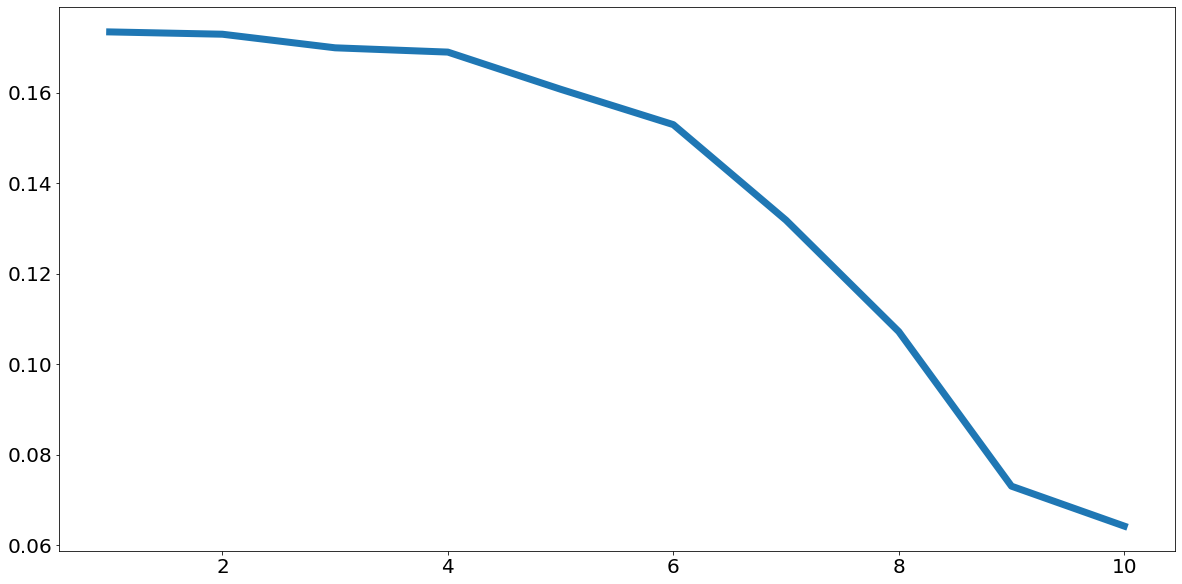

In [ ]:
import matplotlib.pyplot as plt

new_avg_train_loss = avg_train_loss
new_avg_valid_loss = avg_valid_loss

epochs = np.array(range(num_epochs)) + 1
fig = plt.figure()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(20, 10)
# plt.plot(epochs, avg_train_loss, label = 'Average training loss',linewidth=7.0)
plt.plot(epochs, new_avg_train_loss, label = 'Average training loss',linewidth=7.0)
plt.plot(epochs, new_avg_valid_loss, label = 'Average validation loss',linewidth=7.0)
plt.legend(loc='best', prop={'size': 20})
plt.ylabel('Average Loss', fontsize = 20)
plt.xlabel('Epoch Number', fontsize = 20)
plt.show()
print(f'The accuracy of the network on the test set of length {len(test_dataloader) * batch_size} was {acc:.1f}%')